# Naive Bayes Model for Binary Classification

This notebook performs `binary sentiment classification` with `Naive Bayes model`.

The dataset used is `GoEmotions` which contains 58k comments from Reddit provided by Google.
- It is taken directly from here (https://github.com/google-research/google-research/tree/master/goemotions).

Flow of the notebook is as follows:
1. Data Processing
2. Model Training
3. Making Predictions
4. Evaluation

First, import libraries.

In [1]:
# download packages if they are not installed
# !pip install nltk
# !pip install emoji

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import RegexpTokenizer
import emoji

from collections import defaultdict

import os
import json

path = os.getcwd() + '/nb_data'
print(f'Data path: {path}')

Data path: /Users/hjy/nlp_models/naive_bayes/nb_data


## 1. Data Processing

For the simplicity of the model (that is to perform binary classification),
- Take the first emotion if there are several emotions labeled.
- Convert sentiments to either `positive(1)` or `negative(0)`. 


In [3]:
# call data
columns = ('text', 'emotion', 'id')

train = pd.read_csv(path + '/train.csv', sep='\t', names=columns)
test = pd.read_csv(path + '/test.csv', sep='\t', names=columns)


# get emotion mapping data
emotions = []
with open(path + '/emotions.txt', 'r') as file:
    for line in file.readlines():
        emotions.append(line.strip('\n'))
    
print(emotions)

# get sentiment dictionary
with open(path + '/sentiment_dict.json', 'r') as file:
    sent_dict = json.load(file)
    
print('\n', sent_dict)

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']

 {'positive': ['amusement', 'excitement', 'joy', 'love', 'desire', 'optimism', 'caring', 'pride', 'admiration', 'gratitude', 'relief', 'approval'], 'negative': ['fear', 'nervousness', 'remorse', 'embarrassment', 'disappointment', 'sadness', 'grief', 'disgust', 'anger', 'annoyance', 'disapproval'], 'ambiguous': ['realization', 'surprise', 'curiosity', 'confusion']}


In [4]:
def num2sent(numbs, emotions=emotions, sent_dict=sent_dict):
    '''
    return 1 if the first emotion is positive, 0 if emotion is negative, and -1 if ambiguous
    '''
    # get the first emotion
    numb = int(numbs.split(',')[0])
    
    # set label to 1 if positive, 0 if negative and -1 if ambiguous
    sent2num = {'positive':int(1), 'negative':int(0), 'ambiguous':int(-1)}
    
    for senti in sent_dict.keys():
        if emotions[numb] in sent_dict[senti]:
            return sent2num[senti]

        
train['emotion'] = train['emotion'].map(num2sent)
test['emotion'] = test['emotion'].map(num2sent)

train = train[train['emotion'] > -1]
test = test[test['emotion'] > -1]


train_x = train['text'].to_numpy()
train_y = train['emotion'].to_numpy()

test_x = test['text'].to_numpy()
test_y = test['emotion'].to_numpy()

del train, test

In [5]:
# print number of train and test examples
print(f'Number of train examples: {len(train_x)} \nNumber of test examples: {len(test_x)}')

# print n examples
n = 10

print('\nTraining data examples:\n')
for i in range(n):
    print(f'Text data: {train_x[i]}\nLabel: {train_y[i]}\n')

Number of train examples: 26098 
Number of test examples: 3248

Training data examples:

Text data: WHY THE FUCK IS BAYLESS ISOING
Label: 0.0

Text data: To make her feel threatened
Label: 0.0

Text data: Dirty Southern Wankers
Label: 0.0

Text data: Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝
Label: 1.0

Text data: We need more boards and to create a bit more space for [NAME]. Then we’ll be good.
Label: 1.0

Text data: Damn youtube and outrage drama is super lucrative for reddit
Label: 1.0

Text data: Aww... she'll probably come around eventually, I'm sure she was just jealous of [NAME]... I mean, what woman wouldn't be! lol 
Label: 1.0

Text data: R/sleeptrain Might be time for some sleep training. Take a look and try to feel out what's right for your family.
Label: 1.0

Text data: [NAME] - same fucking problem, slightly better command of the English language.
Label: 0.0

Text data: Shit, I guess I accidentally

There are more data which is positive than negative. Later, we will multiply prior to compensate the imbalance.

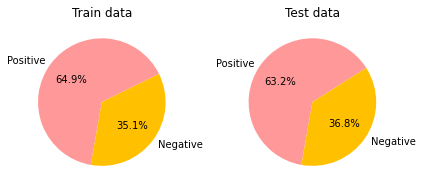

In [6]:
# count the ratio of positive and negative sentiment in train and test data

# get data
def len_pos_neg(np_arr):
    len_pos = len(np_arr[np_arr == 1])
    return [len_pos, len(np_arr) - len_pos]

train_ratio = len_pos_neg(train_y)
test_ratio = len_pos_neg(test_y)

labels = ['Positive', 'Negative']
colors = ['#ff9999', '#ffc000']

# draw plots
plt.subplot(1, 2, 1)
plt.pie(train_ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, colors=colors)
plt.title('Train data')

plt.subplot(1, 2, 2)
plt.pie(test_ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, colors=colors)
plt.title('Test data')

plt.tight_layout()
plt.show()

In [7]:
# set data pipeline
def process(s):
    '''process a string sentence data in to a list of tokenized words'''
    
    # First, delete '[NAME]' entities
    s = s.replace('[NAME]', '')
    s = s.replace('[RELIGION]', '')
    
    # set every letter to lower case
    s = s.lower()
    
    # process emojis
    s = emoji.demojize(s)
    
    # tokenize the sentence with RegexpTokenizer
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    s_token = tokenizer.tokenize(s)
    
    return s_token

In [8]:
# test process function
for i in range(n):
    example_s = train_x[i]
    print(f'Raw text: {example_s} \nprocessed : {process(example_s)} \n')

Raw text: WHY THE FUCK IS BAYLESS ISOING 
processed : ['why', 'the', 'fuck', 'is', 'bayless', 'isoing'] 

Raw text: To make her feel threatened 
processed : ['to', 'make', 'her', 'feel', 'threatened'] 

Raw text: Dirty Southern Wankers 
processed : ['dirty', 'southern', 'wankers'] 

Raw text: Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝 
processed : ['yes', 'i', 'heard', 'abt', 'the', 'f', 'bombs', '!', 'that', 'has', 'to', 'be', 'why', '.', 'thanks', 'for', 'your', 'reply', ':)', 'until', 'then', 'hubby', 'and', 'i', 'will', 'anxiously', 'wait', ':squinting_face_with_tongue:'] 

Raw text: We need more boards and to create a bit more space for [NAME]. Then we’ll be good. 
processed : ['we', 'need', 'more', 'boards', 'and', 'to', 'create', 'a', 'bit', 'more', 'space', 'for', '.', 'then', 'we', '’ll', 'be', 'good', '.'] 

Raw text: Damn youtube and outrage drama is super lucrative for reddit 
processed : ['damn', 'y

## 2. Model Training

To get the frequency of `(word, class)` pair from the train data, I implemented `get_freq` but `utils.build_freqs` does the same job.

In [9]:
def get_freq(dd, train_x, train_y):
    '''
    Get frequency dictionary from the training data.
    input:
        dd : a defaultdict of integer.
        train_x : list of tokened sentences of training data.
        train_y : list of 0 or 1 corresponding to the train_x. 
    return:
        result : dictionary of (key, value) = (word label pair, frequency).
    '''
    for sentence, label in zip(train_x, train_y):
        for word in process(sentence):
            dd[(word, label)] += 1

    return dd

# count frequency dictionary from train_x and train_y.
freqs = get_freq(defaultdict(int), train_x, train_y)

To train Naive model is to compute `log_prior` and `log_likelihood` from the training data.  

Let's compute the Naive Bayes in the form:
$$
NB(s) = log\frac{P(Pos)}{P(Neg)} + \sum^{m}_{i=1} log\frac{P(w_i|Pos)}{P(w_i|Neg)}
$$
with Laplacian smoothing on conditional probability:
$$
P(w|class) = \frac{freq(w, class) + 1}{N_{class} + V_{class}}
$$

In [10]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Train Naive Bayes model, that is, get prior and likelihood from the training data.
    return:
        log_prior : an integer. P(Pos) / P(Neg) value.
        log_likelihood : a dictionary of (key, value) = (word, log likelihood)
    '''
    # log_likelihood relies on words
    log_likelihood = dict()
    # log prior value relies on the corpus
    log_prior = 0

    # get unique words from the frequency dict
    vocab = list(set([k[0] for k in freqs.keys()]))
    V = len(vocab)

    # get N_pos and N_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        # if label is 1, the word is positive.
        if pair[1] == 1:
            N_pos += freqs[pair]
        # if label is 0, the word is negative.
        else:
            N_neg += freqs[pair]

    # get log likelihood
    for w in vocab:
        # get positive and negative frequency of word w.
        freq_pos = freqs.get((w, 1), 0)
        freq_neg = freqs.get((w, 0), 0)

        # get P(w|Pos) and P(w|Neg).
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)

        log_likelihood[w] = np.log(p_w_pos) - np.log(p_w_neg)

    # to compute log_prior,
    # get the number of positive and negative labels
    num_label = len(train_y)
    num_pos = len(train_y[train_y == 1])
    num_neg = len(train_y[train_y == 0])

    # log prior = log(P(Pos)) - log(P(Neg))
    log_prior = np.log(num_pos / num_label) - np.log(num_neg / num_label)

    return log_prior, log_likelihood, vocab

In [11]:
# get log prior and log likelihood from the training data
# so that we can train on test data.
log_prior, log_likelihood, vocab = train_naive_bayes(freqs, train_x, train_y)

print(f'log prior: {log_prior}')

for i in range(n):
    print(f'log likelihood for pair ({vocab[i]}, 1): {log_likelihood[(vocab[i])]}')

log prior: 0.6163959534768829
log likelihood for pair (bottle, 1): -0.6573034506496942
log likelihood for pair (figured, 1): 0.7206226607996786
log likelihood for pair (globally, 1): 0.18999440973750836
log likelihood for pair (sales, 1): -0.5031527708224353
log likelihood for pair (civilizations, 1): -1.6017650594905462
log likelihood for pair (yaaaaaas, 1): 0.18999440973750836
log likelihood for pair (*), 1): 0.18999440973750836
log likelihood for pair (tdagarim, 1): 0.18999440973750836
log likelihood for pair (us, 1): -0.03859874634426497
log likelihood for pair (scarecrow, 1): 0.5954595178456721


## 3. Making Predictions

In [12]:
def predict_naive_bayes(s, log_prior, log_likelihood):
    '''
    input:
        s : a list. Input sentence.
        log_prior : log prior from trained naive bayes.
        log_likelihood : log likelihood from trained naive bayes.
    return:
        log_prob : float between 0 and 1. probability that s is positive.
    '''    

    words = process(s)
    log_prob = 0

    for w in words:
        if w in log_likelihood:
            log_prob += log_likelihood[w]

    log_prob += log_prior

    return log_prob

Now let's run some tests with the trained model.

In [13]:
# predict probability on some test data.
test_data = 'hope you get well soon. it hurts to see you ill 😢'
print('prediction:', predict_naive_bayes(test_data, log_prior, log_likelihood))

prediction: 3.5899659770696997


This example seems to predict right. Let's look at the following examples.

In [14]:
test_data = 'the class was in a terrible mood...'
print('prediction:', predict_naive_bayes(test_data, log_prior, log_likelihood))

prediction: -0.9631403029841944


In [15]:
test_data = 'the class was in a terrible mood... haha...'
print('prediction:', predict_naive_bayes(test_data, log_prior, log_likelihood))

prediction: 1.7861563324372813


#### The model takes it hard to predict sarcastic or euphemistic contexts.

In [16]:
test_data = 'boooooring'
prob = predict_naive_bayes(test_data, log_prior, log_likelihood)

print('prediction:', prob)
print(f'Are "{test_data}" and "log_prior" the same in their value?: {prob == log_prior}')

prediction: 0.6163959534768829
Are "boooooring" and "log_prior" the same in their value?: True


#### Note that the word which do not appear in the corpus is not actually computed. 

This is because Naive Bayes rely on word frequency of the given corpus. In later models, this without-vocab words are named 'unknown words' and dealt with fresh ideas.

## 4. Evaluation

To evaluate the model, we need to transform the data into a labeled form. That is, we need to convert the data gained by `predict_naive_bayes` into binary (`1` or `0`) form. 

Note that the neutral value of `log_prob` is `0`, not `1`.

In [17]:
def sign(log_prob):
    return 1 if log_prob > 0 else 0

def get_accuracy(test_x, test_y, log_prior, log_likelihood):
    '''return accuracy of the prediction on test data'''
    
    matches = 0

    for s, label in zip(test_x, test_y):
        l_prob = predict_naive_bayes(s, log_prior, log_likelihood)
        if sign(l_prob) == label:
            matches += 1
            
    return matches / len(test_x) * 100

In [18]:
# get model accuray on the test data
accuracy = get_accuracy(test_x, test_y, log_prior, log_likelihood)
print(accuracy)

81.71182266009852


#### We have achieved 81% accuracy with Naive Bayes Model!